## Preamble

In [ ]:
%load_ext autoreload
%autoreload 0

In [ ]:
%autoreload

In [ ]:
import sys
sys.path.append('/pollard/home/bsmith/Projects/haplo-benchmark/include/StrainFacts')

In [ ]:
import xarray as xr
import sqlite3
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import torch
import pyro
import scipy as sp

import lib.plot
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import AgglomerativeClustering
from lib.pandas_util import idxwhere

import sfacts as sf

from tqdm import tqdm

# from lib.project_style import color_palette, major_allele_frequency_bins
# from lib.project_data import metagenotype_db_to_xarray
# from lib.plot import ordination_plot, mds_ordination, nmds_ordination
# import lib.plot
# from lib.plot import construct_ordered_pallete
# from lib.pandas_util import idxwhere

## Load Data

In [ ]:
species_id = 102492

fit = sf.data.World.load(f'data/zshi.sp-{species_id}.metagenotype.filt-poly05-cvrg25.fit-sfacts44-s200-g5000-seed0.refit-sfacts41-g10000-seed0.world.nc')
fit.data['position'] = fit.data.position.astype(int)
print(fit.sizes)


cull_threshold = 0.05

fit_communities = fit.communities.mlift('sel', strain=fit.communities.max("sample") > cull_threshold)
print((1 - fit_communities.sum("strain")).max())
fit_communities = sf.Communities(fit_communities.data / fit_communities.sum("strain"))
fit_genotypes = fit.genotypes.mlift('sel', strain=fit_communities.strain)

fit = sf.World.from_combined(fit_communities, fit_genotypes, fit.metagenotypes)
print(fit.sizes)

In [ ]:
country_to_continent_map = dict(
    MDG='AF',
    TZA='AF',
    PER='SA',
    USA='NA',
    CAN='NA',
    GBR='EU',
    FRA='EU',
    ITA='EU',
    ESP='EU',
    SWE='EU',
    SVK='EU',
    HUN='EU',
    EST='EU',
    AUT='EU',
    DEU='EU',
    NLD='EU',
    DNK='EU',
    NOR='EU',
    FIN='EU',
    RUS='EU',
    ISL='EU',
    ISR='AS',
    KAZ='AS',
    MNG='AS',
    CHN='AS',
    SGP='AS',
    BRN='AS',
    IDN='AS',
    MYS='AS',
    BGD='AS',
    FJI='OC',
)
country_order = list(country_to_continent_map.keys())

In [ ]:
_a = pd.read_table('raw/shi2021_s8.tsv', index_col=['NCBI Accession Number'])
_b = (
    pd.read_table('raw/shi2021_s7.tsv', index_col=['Sample ID', 'Study'])
    .assign(
        Continent=lambda x: x.Country.map(country_to_continent_map)
    )
)
_c = pd.read_table('raw/shi2021_s13.tsv', index_col=['NCBI Accession Number'])

sample_meta = _a.join(_b, on=['Sample ID', 'Study']).join(_c, rsuffix='_')

assert (
    sample_meta
    .dropna(subset=['Country_'])
    .assign(
        match=lambda x: True
        & (x['Sample ID_'] == x['Sample ID'])
        & (x.Study_ == x.Study) & (x.Country_ == x.Country)
        & (x.Westernized == x['Western Lifestyle'])
    )
    .match
    .all()
)
assert sample_meta[~(sample_meta.Continent_ == sample_meta.Continent)].dropna(subset=['Continent_']).empty

sample_meta = sample_meta.loc[fit.sample]

In [ ]:
sample_meta.groupby(['Continent', 'Country', 'Study']).apply(len)

In [ ]:
fit_dist = fit_genotypes.discretized().pdist()

In [ ]:
dedup_thresh = 0.05

fit_dedup_clust = pd.Series(
    AgglomerativeClustering(
        distance_threshold=dedup_thresh, n_clusters=None, affinity='precomputed', linkage='average'
    ).fit_predict(fit_dist),
    index=fit_dist.columns.astype(int),
)

In [ ]:
fit_genotypes_dedup = sf.Genotypes(fit_genotypes.to_series().unstack('strain').groupby(fit_dedup_clust, axis='columns').mean().rename(columns=lambda x: int(x)).rename_axis(columns='strain').T.stack().to_xarray())
fit_communities_dedup = sf.Communities(fit_communities.to_series().unstack('strain').groupby(fit_dedup_clust, axis='columns').sum().rename(columns=lambda x: int(x)).rename_axis(columns='strain').T.unstack().to_xarray())
fit_dedup = sf.World.from_combined(fit_genotypes_dedup, fit_communities_dedup)

In [ ]:
(fit_genotypes.sizes['strain'], fit_dedup.sizes['strain'])

In [ ]:
n_top_strains = 20
min_samples = 5

m = sample_meta[
    lambda x: True
    & (x['Body Site']=='Stool')
    & (x['Westernized'] == 'Yes')
    & (x['Age Category'] == 'Adult')
    & x['Continent'].notna()
]
d = fit_dedup.sel(sample=m.index)

dominant_strain = d.communities.data.argmax("strain").to_series()
top_strains = list(dominant_strain.value_counts().sort_values(ascending=False).head(n_top_strains).index)

d = (
    dominant_strain
    .to_frame(name='strain')
    .join(sample_meta, how='inner')
    .groupby(['Continent', 'Country', 'Study', 'strain'])
    .apply(len)
    .unstack('strain', fill_value=0)
    .apply(lambda x: x / x.sum(), axis=1)
    .assign(other=lambda x: 1 - x[top_strains].sum(1))
    [top_strains + ['other']]
    [sample_meta.groupby(['Continent', 'Country', 'Study']).apply(len) > min_samples]
)


lib.plot.construct_ordered_pallete(top_strains)

ax = (
    d
    .plot
    .bar(
        width=0.95,
        stacked=True,
        color=lib.plot.construct_ordered_pallete(top_strains, cm='tab20c', other='whitesmoke'),
        figsize=(10, 5)
    )
)
ax.legend(bbox_to_anchor=(1, 1))

In [ ]:
group_thresh = 0.15

fit_group_clust = pd.Series(
    AgglomerativeClustering(
        distance_threshold=group_thresh, n_clusters=None, affinity='precomputed', linkage='average'
    ).fit_predict(fit_dist),
    index=fit_dist.columns.astype(int),
)

In [ ]:
fit_genotypes_group = sf.Genotypes(fit_dedup.genotypes.to_series().unstack('strain').groupby(fit_group_clust, axis='columns').mean().rename(columns=lambda x: int(x)).rename_axis(columns='strain').T.stack().to_xarray())
fit_communities_group = sf.Communities(fit_dedup.communities.to_series().unstack('strain').groupby(fit_group_clust, axis='columns').sum().rename(columns=lambda x: int(x)).rename_axis(columns='strain').T.unstack().to_xarray())
fit_group = sf.World.from_combined(fit_genotypes_group, fit_communities_group)

In [ ]:
n_top_strains = 20
min_samples = 5

m = sample_meta[
    lambda x: True
    & (x['Body Site']=='Stool')
    & (x['Westernized'] == 'Yes')
    & (x['Age Category'] == 'Adult')
    & x['Continent'].notna()
]
d = fit_group.sel(sample=m.index)

dominant_strain = d.communities.data.argmax("strain").to_series()
top_strains = list(dominant_strain.value_counts().sort_values(ascending=False).head(n_top_strains).index)

d = (
    dominant_strain
    .to_frame(name='strain')
    .join(sample_meta, how='inner')
    .groupby(['Continent', 'Country', 'Study', 'strain'])
    .apply(len)
    .unstack('strain', fill_value=0)
    .apply(lambda x: x / x.sum(), axis=1)
    .assign(other=lambda x: 1 - x[top_strains].sum(1))
    [top_strains + ['other']]
    [sample_meta.groupby(['Continent', 'Country', 'Study']).apply(len) > min_samples]
)


lib.plot.construct_ordered_pallete(top_strains)

ax = (
    d
    .plot
    .bar(
        width=0.95,
        stacked=True,
        color=lib.plot.construct_ordered_pallete(top_strains, cm='tab20c', other='whitesmoke'),
        figsize=(10, 5)
    )
)
ax.legend(bbox_to_anchor=(1, 1))

In [ ]:
from collections import defaultdict

def construct_ordered_pallete(x, cm="Spectral", other="grey", weight=None):
    if weight is None:
        weight = {}
    _weight = defaultdict(lambda: 1.0)
    _weight.update(weight)
    labels = pd.Series(x).unique()
    cm = mpl.cm.get_cmap(cm)
    colormap = defaultdict(lambda: other)
    
    countup = 0
    for s in labels:
        new_countup = countup + _weight[s]
        midpoint = (countup + new_countup) / 2
        colormap[s] = midpoint
        countup = new_countup
    for s in colormap:
        colormap[s] = cm(colormap[s] / countup)
        
    return colormap

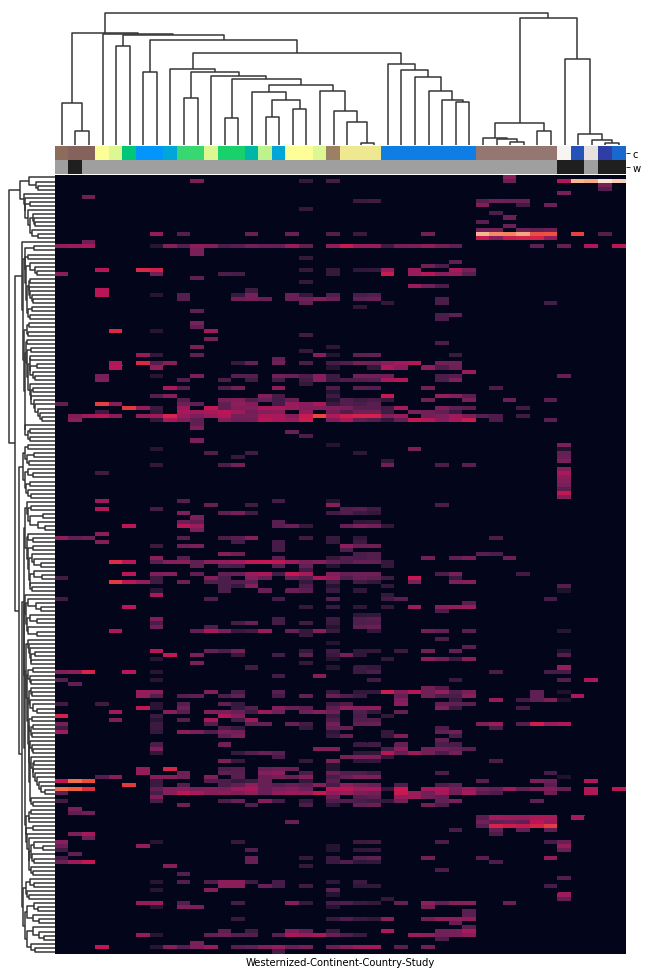

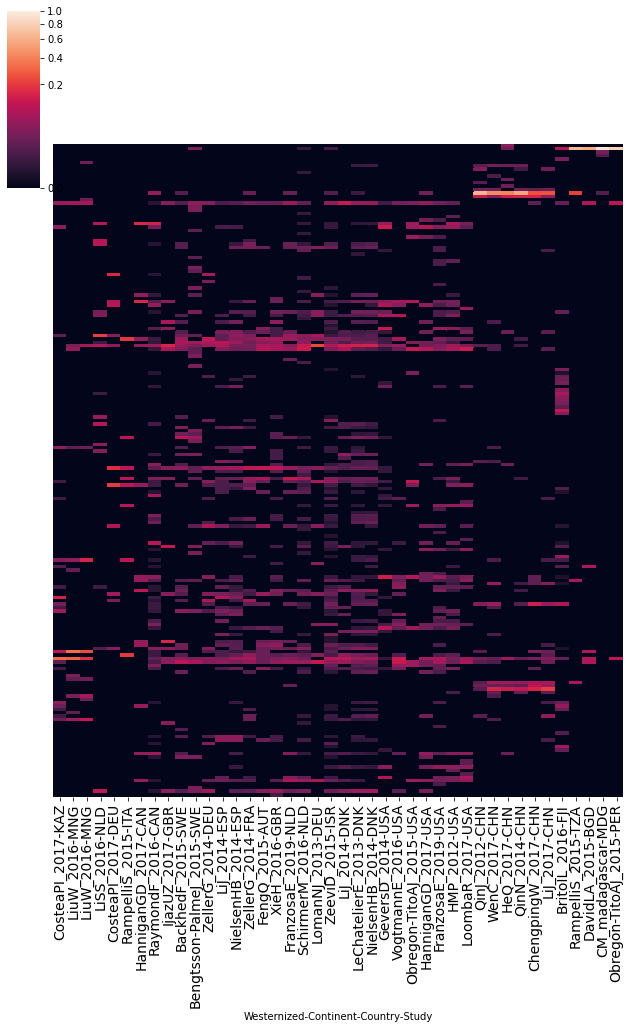

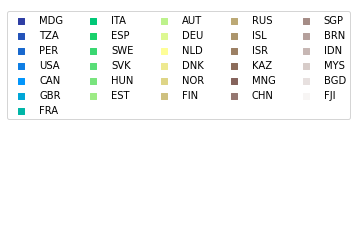

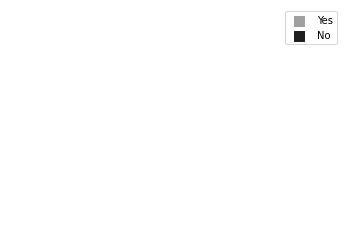

In [144]:
n_top_strains = 10000
min_samples = 10
groupby = ['Westernized', 'Continent', 'Country', 'Study']

_meta = sample_meta[
    lambda x: True
    & (x['Body Site']=='Stool')
#     & (x['Westernized'] == 'Yes')
    & (x['Age Category'] == 'Adult')
    & x['Continent'].notna()
]
_fit = fit_dedup.sel(sample=_meta.index)

d0 = (
    _fit
    .communities
    .data
    .to_series()
    .unstack()
    .idxmax(1)
    .to_frame(name='strain')
    .assign(dummy=1)
    .reset_index()
    .set_index(['sample', 'strain'])
    .squeeze()
    .unstack(fill_value=0)
)
top_strains = list(d0.sum().sort_values(ascending=False).head(n_top_strains).index)

d1 = (
    d0[top_strains].assign(other=d0.drop(columns=top_strains).sum(1).astype(int))
)

d2 = (
    d1
    [top_strains + ['other']]
    .join(_meta[groupby], how='inner')
)

d3 = (
    d2
    .groupby(groupby)
    .mean()
    [d2.groupby(groupby).apply(len) >= min_samples]
)

# continent_palette = lib.plot.construct_ordered_pallete(_meta.Continent.unique(), cm='Spectral_r')
country_palette = construct_ordered_pallete(
    country_order,
    cm='terrain',
    weight=dict(CHN=1)
)
westernized_palette = construct_ordered_pallete(
    ['Yes', 'No'],
    cm='binary',
    weight=dict(Yes=3)
)
# westernized_palette = dict(No=(0, 0, 0, 0), Yes=(1, 1, 1, 1))


# Plot once without ylabels
(fwidth, fheight), dendrogram_ratio, colors_ratio = sf.plot._calculate_clustermap_sizes(
    d3.shape[0], d3.shape[1], n_col_colors=0, n_row_colors=2, scaley=0.05, scalex=0.2, cheight=0.2, dheight=2, dwidth=0.7,
)
clstmap = sns.clustermap(
    d3.T + 1e-10,
    norm=mpl.colors.PowerNorm(1/3, vmin=0, vmax=1),
    xticklabels=0,
    yticklabels=0,
    metric='cosine',
    row_linkage=_fit.sel(strain=top_strains).genotypes.discretized().linkage(),
    col_colors=pd.DataFrame(dict(
        c=d3.index.to_frame().Country.map(country_palette),
#         continent=d3.index.to_frame().Continent.map(continent_palette),
        w=d3.index.to_frame().Westernized.map(westernized_palette),
    )),
    figsize=(fwidth, fheight),
    dendrogram_ratio=dendrogram_ratio,
    colors_ratio=colors_ratio,
    rasterized=True,
    tree_kws=dict(lw=1.5),
)
clstmap.ax_cbar.set_visible(False)
clstmap.fig.savefig(f'fig/biogeography_{species_id}.png', dpi=400)

# Plot once with xlabels and cbar for manual figure building
clstmap = sns.clustermap(
    d3.T + 1e-10,
    norm=mpl.colors.PowerNorm(1/3, vmin=0, vmax=1),
    xticklabels=d3.index.to_frame()[['Country', 'Study']].apply(lambda x: f'{x.Study}-{x.Country}', axis=1).values,
    yticklabels=0,
    metric='cosine',
    row_linkage=_fit.sel(strain=top_strains).genotypes.discretized().linkage(),
    col_colors=pd.DataFrame(dict(
        c=d3.index.to_frame().Country.map(country_palette),
#         continent=d3.index.to_frame().Continent.map(continent_palette),
        w=d3.index.to_frame().Westernized.map(westernized_palette),
    )),
    figsize=(fwidth, fheight),
    dendrogram_ratio=dendrogram_ratio,
    colors_ratio=colors_ratio,
    rasterized=True,
    tree_kws=dict(lw=1.5),
)
clstmap.ax_heatmap.set_xticklabels(clstmap.ax_heatmap.get_xmajorticklabels(), fontsize=14)
clstmap.ax_row_dendrogram.set_visible(False)
clstmap.ax_col_dendrogram.set_visible(False)
clstmap.ax_col_colors.set_visible(False)
clstmap.fig.savefig(f'fig/biogeography_{species_id}_figelements.png', dpi=400)

fig, ax = plt.subplots()
for country in country_palette:
    ax.scatter([], [], c=[country_palette[country]], marker='s', label=country)
ax.legend(ncol=5)
ax.axis('off')
fig.savefig(f'fig/biogeography_{species_id}_legend.png', dpi=400)

fig, ax = plt.subplots()
for westernized in westernized_palette:
    ax.scatter([], [], c=[westernized_palette[westernized]], marker='s', s=100, label=westernized)
ax.legend(ncol=1)
ax.axis('off')
fig.savefig(f'fig/biogeography_{species_id}_legend_westernized.png', dpi=400)

In [152]:
d3.index.get_level_values('Study').unique().shape, d3.index.get_level_values('Country').unique().shape

((33,), (20,))

In [ ]:
(fwidth, fheight)

In [ ]:
n_top_strains = 10000
min_samples = 10
groupby = ['Westernized', 'Continent', 'Country', 'Study']

_meta = sample_meta[
    lambda x: True
    & (x['Body Site']=='Stool')
#     & (x['Westernized'] == 'Yes')
    & (x['Age Category'] == 'Adult')
    & x['Continent'].notna()
]
_fit = fit_dedup.sel(sample=_meta.index)

d0 = (
    _fit
    .communities
    .data
    .to_series()
    .unstack()
    .idxmax(1)
    .to_frame(name='strain')
    .assign(dummy=1)
    .reset_index()
    .set_index(['sample', 'strain'])
    .squeeze()
    .unstack(fill_value=0)
)
top_strains = list(d0.sum().sort_values(ascending=False).head(n_top_strains).index)

d1 = (
    d0[top_strains].assign(other=d0.drop(columns=top_strains).sum(1).astype(int))
)


(
    d0.shape,
    d1.join(_meta[groupby]).groupby('Study').apply(len).shape,
    (  # How many strains show up in at least 3 continents?
        d1
        .join(_meta[groupby], how='inner')
        .groupby('Continent')
        .mean()
        .apply(lambda x: x > 0)
        .sum()
        .apply(lambda x: x >= 3)
    #     .mean()
        .sum()
    ),
)